In [1]:
# a clean version of the data analysis code


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np 
import json
import os
import rosbag
from sensor_msgs.msg import JointState
import scipy
from scipy.stats import f_oneway
import random

In [2]:
# utils for reading bag files 

def read_bag(bagdir):
    bag = rosbag.Bag(bagdir,'r')
    messages = []
    for _,msg,_ in bag.read_messages(topics=['/my_gen3_lite/joint_states']):
        temp = JointState()
        temp.header = msg.header
        temp.position = msg.position
        temp.velocity = msg.velocity
        temp.name = msg.name
        temp.effort = msg.effort
        messages.append(temp)
    # print("messages length: ",len(messages))
    return messages

def get_all_bag_file_dict(file_path:str=None):
    if file_path is not None:
        file_dir = file_path
    else:
    # use default bag file location
        bag_file_list = []
        bag_file_dict = dict()
        file_dir = os.path.dirname(
                os.path.dirname(
                    os.path.abspath('')
        ))
        file_dir = os.path.join(file_dir,"scripts/bags/")
        print(file_dir)
    # look through directory to find all bag files
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            if file.endswith(".bag"):
                # print(file.split('/'))
                bag_file_dict[root.split('/')[-1]] = os.path.join(root,file)
                bag_file_list.append(os.path.join(root,file))
    return bag_file_dict

def whole_bag_to_messages(bag_file_dict):
    message_dict = dict()
    for user_id, file_name in bag_file_dict.items():
        messages = read_bag(file_name)
        message_dict[user_id] = messages
    return message_dict

# find all json files in a path
def find_json_files(path):
    import os
    json_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

# load json file from a list of json files, store them in a dictionary, key is the file name without .json
def load_json_files(json_files):
    data = {}
    for file in json_files:
        with open(file, 'r') as f:
            data[os.path.basename(file).split('.')[0]] = json.load(f)
    return data

In [3]:
# utils for forward kinematics

# DF parameters to transformation matrix
def transf_dh(a, alpha, d, theta):
    # input degrees, output radians
    alpha = np.deg2rad(alpha)
    theta = np.deg2rad(theta)
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha), np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta), np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0, np.sin(alpha), np.cos(alpha), d],
        [0, 0, 0, 1]
    ])

# forward kinematics for Kinova Gen3 Lite
def forward_kinematics(q):
    # q is a nx6
    end_effector_pose = np.zeros((len(q), 6))
    for i in range(len(q)):
        # q radian to degree
        q[i] = np.rad2deg(q[i])
        T56=transf_dh(0,0,0.105+0.130,q[i,5]+90)
        T45=transf_dh(0,90,0.0285*2,q[i,4]+180)
        T34=transf_dh(0,90,0.140+0.105,q[i,3]+90)
        T23=transf_dh(0,90,0.020,q[i,2]+90)
        T12=transf_dh(0.280,180,0.030,q[i,1]+90)
        T01=transf_dh(0,90,0.1283+0.115,q[i,0])
        T06 = T01.dot(T12).dot(T23).dot(T34).dot(T45).dot(T56)
        # get position and orientation
        end_effector_pose[i,0:3] = T06[0:3,3]
        # get row pitch yaw
        scipy.spatial.transform.Rotation.from_matrix(T06[0:3,0:3]).as_euler('zyx')
        end_effector_pose[i,3:6] = scipy.spatial.transform.Rotation.from_matrix(T06[0:3,0:3]).as_euler('zyx')
    return end_effector_pose

In [4]:
# extract necessary information from messages

# get all eef positions from joint pose in a list of messages
def get_all_eef_positions(message_list):
    all_eef_positions = dict()
    for user_id, user_message in message_list.items():
        # print(type(user_message))
        joint_state = np.zeros([len(user_message), 6])
        for i in range(len(user_message)):
            # print(user_message[i])
            # print(user_message[i].position[:6].shape)
            joint_state[i] = np.array(user_message[i].position[:6])
        all_eef_positions[str(user_id)] = forward_kinematics(joint_state)
    return all_eef_positions

# get all task changes from annotation data
def get_all_task_phase_change(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_task_phase_change = dict()
    for user_id, annotation_data_single in annotation_data.items():
        task_phase_change = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "task phase change":
                task_phase_change.append(annotation["step"])
            # if the step is <0 , make it 0
            task_phase_change = [0 if x < 0 else x for x in task_phase_change]
            # sort the list
            task_phase_change.sort()
        # print(len(task_phase_change))
        if len(task_phase_change)<8 or len(task_phase_change)>8:
            print(user_id)
        all_task_phase_change[user_id] = task_phase_change
    return all_task_phase_change

# get all test controller actions from annotation data
def get_all_test_controller_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_test_controller_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        test_controller_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "test controller":
                test_controller_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_test_controller_actions[user_id] = test_controller_actions
    return all_test_controller_actions

# get all false actions from annotation data
def get_all_false_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_false_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        false_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "false control":
                false_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_false_actions[user_id] = false_actions
    return all_false_actions

# get all alignment actions from annotation data
def get_all_alignment_actions(annotation_data):
    # read every list of dictionary in the json file, store step if annotation key is  "task phase change"
    all_alignment_actions = dict()
    for user_id, annotation_data_single in annotation_data.items():
        alignment_actions = []
        for annotation in annotation_data_single:
            if annotation['annotation'] == "alignment":
                alignment_actions.append([annotation["action_step_start"], annotation["action_step_end"]])
        all_alignment_actions[user_id] = alignment_actions
    return all_alignment_actions

# get all pauses from eef positions
def get_all_pauses(eef_poses_dict:dict):
    pauses_list_all = dict()
    threshold = 0.003
    for user_id, eef_poses_list in eef_poses_dict.items():
        # get element differences
        eef_diff = np.abs(np.diff(eef_poses_list.sum(axis=-1)))
        # get all differences lower than threshold:
        exceed_threshold = eef_diff > threshold
        change_points = np.where(np.diff(exceed_threshold))[0] + 1
        change_points = np.concatenate(([0],change_points,[len(eef_poses_list)-1]))

        subsequences = []
        for i in range(len(change_points) - 1):
            start = change_points[i]
            end = change_points[i+1]

            if np.all(eef_diff[start:end]<= threshold) and end >= start+5:
                subsequences.append([start,end])
        subsequences = [[start + 1, end if end == len(eef_poses_list)-1 else end+1] for start,end in subsequences]
        pauses_list_all[user_id] = subsequences
    return pauses_list_all

# merge all actions
def merge_actions(test_controller_actions:dict, false_actions:dict, alignment_actions:dict, pause_actions:dict = None):
    all_actions = dict()
    # if any action is None, create an empty dictionary
    if pause_actions is None:
        pause_actions = dict()
    
    # make sure all user_ids are in all dictionaries
    for user_id in test_controller_actions.keys():
        if user_id not in false_actions.keys():
            false_actions[user_id] = []
        if user_id not in alignment_actions.keys():
            alignment_actions[user_id] = []
        if user_id not in pause_actions.keys():
            pause_actions[user_id] = []

    for user_id in test_controller_actions.keys():
        all_actions[user_id] = test_controller_actions[user_id] + false_actions[user_id] + alignment_actions[user_id] + pause_actions[user_id]
        all_actions[user_id].sort()
    return all_actions

In [5]:
# functions for cleaning up data

def move_step_start_forward(end_effector_pose, step_start, step_end):
    original_step = step_start
    if step_start == step_end:
        return step_start
    while np.abs(np.array(end_effector_pose[step_start][:5]) - np.array(end_effector_pose[original_step + 1][:5])).sum() < 0.02\
          and  np.abs(np.array(end_effector_pose[step_start][5]) - np.array(end_effector_pose[original_step + 1][5])) < 0.005:
        step_start += 1
        if step_start == step_end:
            break
    return step_start

# remove pause steps happened in [step, step_end]
def clear_pause_steps(end_effector_pose, step_start, step_end, move_start_forward = True):

    if move_start_forward == True:
        # move step_start forward if the end effector is not moving
        step_start = move_step_start_forward(end_effector_pose, step_start, step_end)
        return step_start

    # remove pause steps
    


In [6]:
# functions for procssing annotation data relative to task phase change
def calculate_percentage_to_phase_change(all_task_phase_change, false_actions, eef_poses_dict):
    percentage_to_phase_change = dict()
    closest_phase_change_index = dict()
    steps_to_phase_change = dict()
    for user_id, task_phase_change in all_task_phase_change.items():
        user_eef_poses = eef_poses_dict[user_id]
        task_phase_change = np.array(task_phase_change)
        percentage_to_phase_change[user_id] = []
        closest_phase_change_index[user_id] = []
        steps_to_phase_change[user_id] = []
        for action in false_actions[user_id]:
            # find the closest previous task phase change
            # for act in action:
            act = action[0]
            
            # clear pause steps
            act = clear_pause_steps(user_eef_poses, act, action[1])

            # ignore all actions after task end
            if act > task_phase_change[-1]:
                continue
            closest_phase_change = task_phase_change[task_phase_change <= act]
            if len(closest_phase_change) == 0:
                closest_phase_change = 0
                closest_phase_change_index[user_id].append(0)
            else:
                closest_phase_change = closest_phase_change.max()
                # get the index of the closest phase change
                closest_phase_change_idx_single = np.where(task_phase_change == closest_phase_change)[0][0]
                closest_phase_change_index[user_id].append(closest_phase_change_idx_single)
            # calculate the percentage of action from closest task phase change to next task phase change
            # if there is no next task phase change, calculate the percentage to the end of the task
            # if there is no previous task phase change, calculate the percentage to the start of the task
            
            next_phase_change = task_phase_change[task_phase_change > act]
            
            if len(next_phase_change) == 0:
                next_phase_change = task_phase_change.max()
            else:
                next_phase_change = next_phase_change.min()
            
            # next_phase_change = clear_pause_steps(user_eef_poses, next_phase_change, task_phase_change+10)
            # clear phase change steps
            # print(closest_phase_change, next_phase_change, task_phase_change.max()-1)
            closest_phase_change = clear_pause_steps(user_eef_poses, closest_phase_change, min(next_phase_change, task_phase_change.max()))
            next_phase_change_index = np.where(task_phase_change == next_phase_change)[0][0]
            next_phase_change = clear_pause_steps(user_eef_poses, next_phase_change, task_phase_change[min(next_phase_change_index+1, len(task_phase_change)-1)])
            if next_phase_change == closest_phase_change:
                print(user_id, act, closest_phase_change, next_phase_change)
                percentage = 0
                steps = 0
            else:
                percentage = (act - closest_phase_change)/(next_phase_change - closest_phase_change)
                steps = (act - closest_phase_change)
            percentage_to_phase_change[user_id].append(percentage)
            steps_to_phase_change[user_id].append(steps)
            
            # calculate the percentage to the closest task phase change
            # measured by dist from 
    return percentage_to_phase_change, closest_phase_change_index, steps_to_phase_change

In [7]:
# plot phase when alignment happens
def get_alignment_phase(all_alignment_actions, all_task_phase_change):
    alignment_phase = dict()
    for user_id, alignment_actions in all_alignment_actions.items():
        alignment_phase[user_id] = []
        for action in alignment_actions:
            for i in range(len(all_task_phase_change[user_id])):
                if all_task_phase_change[user_id][i] < action[0] < all_task_phase_change[user_id][i+1]:
                    alignment_phase[user_id].append(i)
                    break
    return alignment_phase


In [8]:
# read annotations
json_path = os.path.dirname(
        os.path.abspath('')
)

json_path = os.path.join(json_path, 'annotations')
print(json_path)
annotation_files = find_json_files(json_path)
print(len(annotation_files))
annotation_data = load_json_files(annotation_files)

# get all bag files and messages
bag_file_dict = get_all_bag_file_dict()
message_dict = whole_bag_to_messages(bag_file_dict)

# get all eef positions
eef_poses_dict = get_all_eef_positions(message_dict)

/home/frank/human-error/src/replayer/scripts/annotations
40
/home/frank/human-error/src/replayer/scripts/bags/


In [9]:
# get all basic information

# get all task phase change
all_task_phase_change = get_all_task_phase_change(annotation_data)

# get all test controller actions
all_test_controller_actions = get_all_test_controller_actions(annotation_data)

# get all false actions
all_false_actions = get_all_false_actions(annotation_data)

# get all alignment actions
all_alignment_actions = get_all_alignment_actions(annotation_data)

# get all pauses
all_pauses = get_all_pauses(eef_poses_dict)


user_37
user_28
user_18
user_30
user_35
user_22
user_24


In [10]:
# plot action frequency

# merge all actions
all_actions = merge_actions(all_test_controller_actions, all_false_actions, all_alignment_actions, all_pauses)
all_actions_with_pause = merge_actions(all_test_controller_actions, all_false_actions, all_alignment_actions)

# get phase change index
_, closest_phase_change_index_all_actions,_ = calculate_percentage_to_phase_change(all_task_phase_change, all_actions, eef_poses_dict)

# plot number of actions in each phase
def get_action_frequency_per_phase(certain_actions, all_task_phase_change):
    result = np.zeros(8)

    for user_id in all_test_controller_actions.keys():
        for action in certain_actions[user_id]:
            # if action is before the task starts
            if action[0] < all_task_phase_change[user_id][0]:
                result[0] += 1
                continue
            # we don't care actions after the task ends
            elif action[0] > all_task_phase_change[user_id][-1]:
                continue
            for i in range(min(len(all_task_phase_change[user_id]) - 1, 7)):
                if all_task_phase_change[user_id][i] < action[0] < all_task_phase_change[user_id][i+1]:
                    result[i+1] += 1
                    break
    return result


action_frequency_test_controller = get_action_frequency_per_phase(all_test_controller_actions, all_task_phase_change)
action_frequency_false_actions = get_action_frequency_per_phase(all_false_actions, all_task_phase_change)
action_frequency_alignment_actions = get_action_frequency_per_phase(all_alignment_actions, all_task_phase_change)   
action_frequency_pauses = get_action_frequency_per_phase(all_pauses, all_task_phase_change)


user_30 333 343 343
user_30 340 343 343
user_10 244 244 244
user_24 2 3 3


In [11]:
def get_action_steps_per_phase(certain_actions, all_task_phase_change):
    result = np.zeros(8)

    for user_id in all_test_controller_actions.keys():
        for action in certain_actions[user_id]:
            # if action is before the task starts
            for single_action in action:
                if single_action < all_task_phase_change[user_id][0]:
                    result[0] += 1
                    continue
                # we don't care actions after the task ends
                elif single_action > all_task_phase_change[user_id][-1]:
                    continue
                for i in range(min(len(all_task_phase_change[user_id]) - 1, 7)):
                    if all_task_phase_change[user_id][i] < single_action < all_task_phase_change[user_id][i+1]:
                        result[i+1] += 1
                        break
    return result


action_steps_test_controller = get_action_steps_per_phase(all_test_controller_actions, all_task_phase_change)
action_steps_false_actions = get_action_steps_per_phase(all_false_actions, all_task_phase_change)
action_steps_alignment_actions = get_action_steps_per_phase(all_alignment_actions, all_task_phase_change)
action_steps_pauses = get_action_steps_per_phase(all_pauses, all_task_phase_change)

In [12]:
def get_action_steps_per_participant(certain_actions):
    result = dict()
    for user_id in certain_actions.keys():
        for action in certain_actions[user_id]:
            if user_id not in result.keys():
                result[user_id] = 0
            result[user_id] += (action[1] - action[0])
            
    return result

action_steps_per_participant_test_controller = get_action_steps_per_participant(all_test_controller_actions)
action_steps_per_participant_false_actions = get_action_steps_per_participant(all_false_actions)
action_steps_per_participant_alignment_actions = get_action_steps_per_participant(all_alignment_actions)
action_steps_per_participant_pauses = get_action_steps_per_participant(all_pauses)
# print(action_steps_per_participant_test_controller)

<Figure size 2000x500 with 0 Axes>

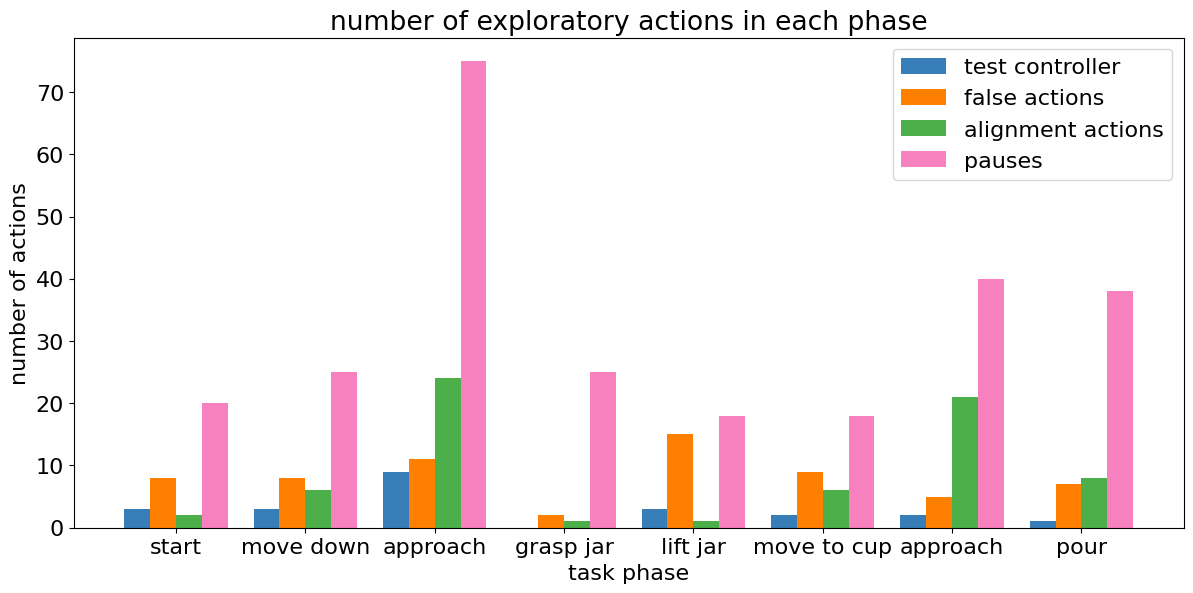

In [13]:
def plot_frequencies(action_frequency_test_controller, action_frequency_false_actions, action_frequency_alignment_actions, action_frequency_pauses):
    # make plot wider
    plt.figure(figsize=(20,5))
    # fig, ax = plt.subplots()
    # plot each type of action as neighouring bars
    x = np.arange(8)
    width = 0.2
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16*2   # width in inches
    fig_height = (fig_width / 36) * 8 *2# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height))

    plt.bar(x, action_frequency_test_controller, width, label='test controller')
    plt.bar(x + width, action_frequency_false_actions, width, label='false actions')
    plt.bar(x + 2*width, action_frequency_alignment_actions, width, label='alignment actions')
    plt.bar(x + 3*width, action_frequency_pauses, width, label='pauses')
    plt.xlabel('task phase')
    plt.ylabel('number of actions')
    plt.title('number of exploratory actions in each phase')
    task_phases = ["start", "move down", "approach", "grasp jar", "lift jar", "move to cup", "approach", "pour"]
    plt.xticks(x + 1.5*width, task_phases)

    plt.legend()
    plt.show()

plot_frequencies(action_frequency_test_controller, action_frequency_false_actions, action_frequency_alignment_actions, action_frequency_pauses)

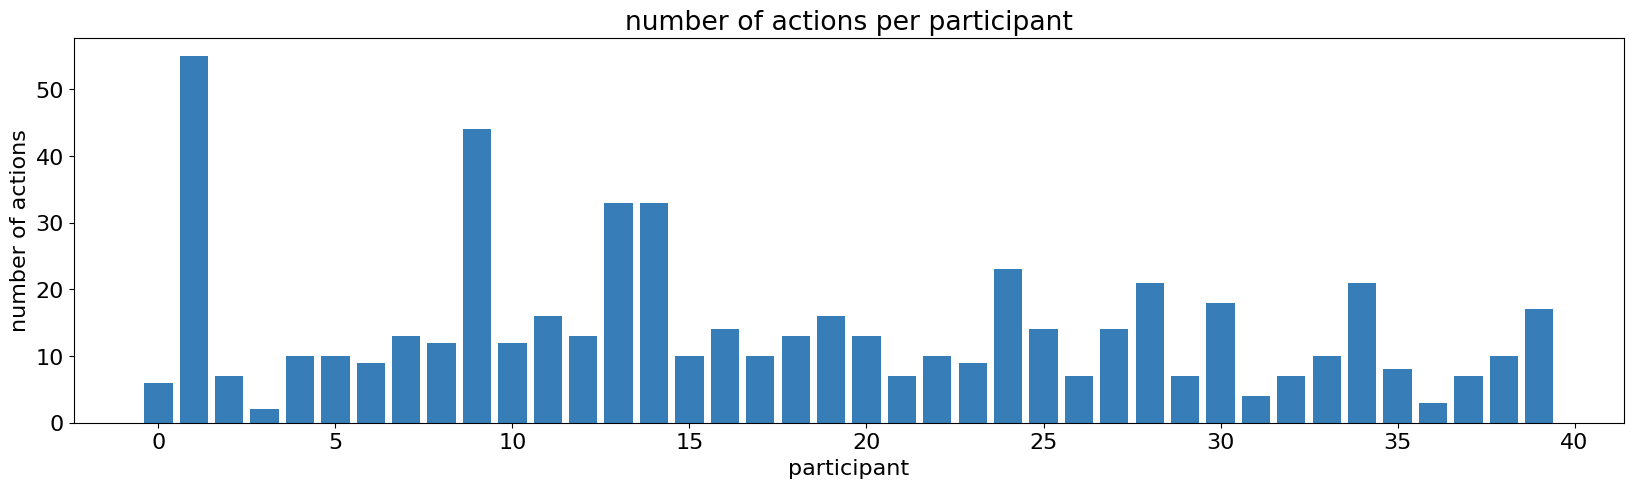

average number of actions:  14.2


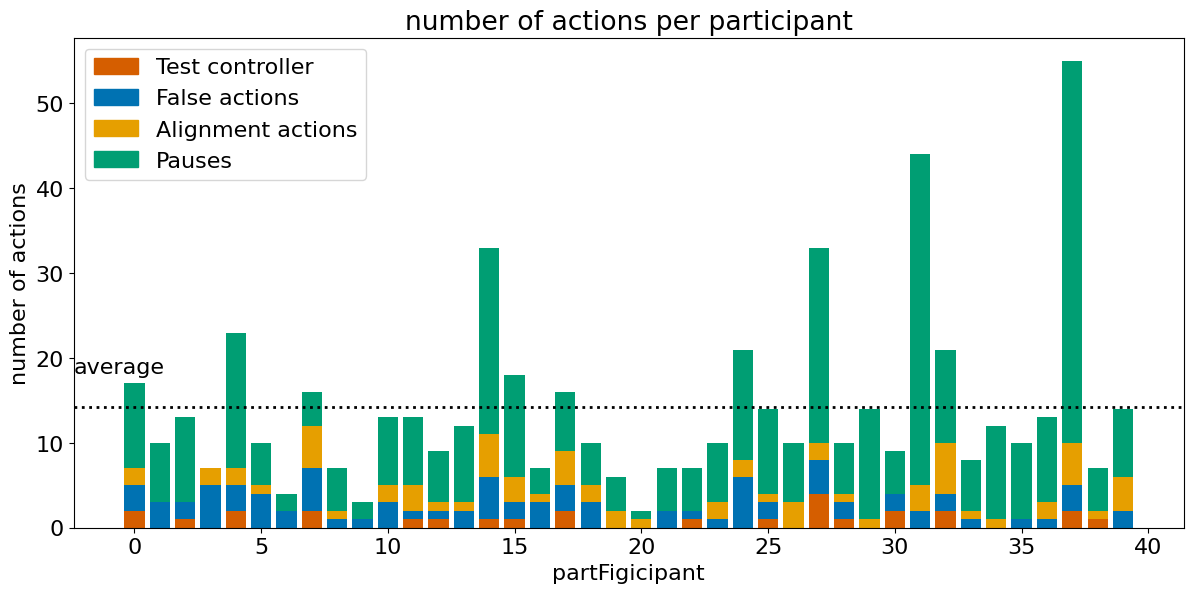

average types of actions per participant:  3.05
number of participants with more than 3 types of actions:  29
number of participants with test controller actions:  17
f value:  30.92140784284544
p value:  9.620327927139875e-16


In [14]:
# plot number of overall actions per participant

def plot_num_actions_per_participant(all_actions):
    num_actions = []
    plt.figure(figsize=(20,5))
    for user_id, actions in all_actions.items():
        num_actions.append(len(actions))
    plt.bar(range(len(all_actions.keys())), num_actions)
    plt.xlabel('participant')
    plt.ylabel('number of actions')
    plt.title('number of actions per participant')
    plt.show()


def get_action_per_participant_with_type(all_test_controller_actions, all_false_actions, all_alignment_actions, all_pauses):
    all_actions = dict()
    for user_id in all_test_controller_actions.keys():
        all_actions[user_id] = [len(all_test_controller_actions[user_id]), len(all_false_actions[user_id]), len(all_alignment_actions[user_id]), len(all_pauses[user_id])]
    return all_actions
  
def plot_action_per_participant_with_type(action_per_participant_with_type:dict):
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16*2   # width in inches
    fig_height = (fig_width / 36) * 8 *2# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height))
    # color = ['#377eb8', '#ff7f00', '#4daf4a',
    #               '#f781bf', '#a65628', '#984ea3',
    #               '#999999', '#e41a1c', '#dede00']
    color = ["#D55E00", "#0072B2", "#E69F00", "#009E73", "#F0E442", "#56B4E9"]

            # shuffle
    # random.shuffle(color)
    # loop through all participants
    for i in range(40):
        if f"user_{i}" in action_per_participant_with_type.keys():
            # plot different types of actions on top of each other
            # use the same color for the same type of action
            
            plt.bar(i, action_per_participant_with_type[f"user_{i}"][0], label='test controller', color=color[0])
            plt.bar(i, action_per_participant_with_type[f"user_{i}"][1], bottom=action_per_participant_with_type[f"user_{i}"][0], label='false actions', color=color[1])
            plt.bar(i, action_per_participant_with_type[f"user_{i}"][2], bottom=action_per_participant_with_type[f"user_{i}"][0]+action_per_participant_with_type[f"user_{i}"][1], label='alignment actions', color=color[2])
            plt.bar(i, action_per_participant_with_type[f"user_{i}"][3], bottom=action_per_participant_with_type[f"user_{i}"][0]+action_per_participant_with_type[f"user_{i}"][1]+action_per_participant_with_type[f"user_{i}"][2], label='pauses', color=color[3])
    #manual legend since we are plotting multiple times  
    test_controller_patch = mpatches.Patch(color=color[0], label='Test controller')
    false_actions_patch = mpatches.Patch(color=color[1], label='False actions')
    alignment_actions_patch = mpatches.Patch(color=color[2], label='Alignment actions')
    pauses_patch = mpatches.Patch(color=color[3], label='Pauses')

    # add a dotted line for average number of actions

    # figure size that is compatible with IEEE double column
    # fig_width = 7.16/2
    # fig_height = (fig_width / 36) * 8
    # plt.figure(figsize=(fig_width, fig_height*5))
    # make text bigger for readability
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.axhline(y=np.mean([sum(action_per_participant_with_type[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]), color='black', linestyle='dotted', linewidth=2)
    print("average number of actions: ", np.mean([sum(action_per_participant_with_type[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]))
    plt.text(-2.4, 4 + np.mean([sum(action_per_participant_with_type[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]), 'average', color='black')
    # add legend for dotted line

    # make labels readable bigger


    plt.xlabel('partFigicipant')
    plt.ylabel('number of actions')
    plt.title('number of actions per participant')
    plt.legend(handles=[test_controller_patch, false_actions_patch, alignment_actions_patch, pauses_patch])
    plt.show()


plot_num_actions_per_participant(all_actions)
action_per_participant_with_type = get_action_per_participant_with_type(all_test_controller_actions, all_false_actions, all_alignment_actions, all_pauses)
plot_action_per_participant_with_type(action_per_participant_with_type)
action_types_per_participant = []
for user_id in action_per_participant_with_type.keys():
    # get the length of non-zero actions
    action_types_per_participant.append(len([x for x in action_per_participant_with_type[user_id] if x != 0]))

print("average types of actions per participant: ", np.mean(action_types_per_participant))
print("number of participants with more than 3 types of actions: ", len([x for x in action_types_per_participant if x >= 3]))

num_participants_with_test_controller = len([x for x in action_per_participant_with_type.keys() if action_per_participant_with_type[x][0] > 0])
print("number of participants with test controller actions: ", num_participants_with_test_controller)


def one_way_anova(action_per_participant_with_type):
    test_controller = []
    false_actions = []
    alignment_actions = []
    pauses = []
    for user_id in action_per_participant_with_type.keys():
        test_controller.append(action_per_participant_with_type[user_id][0])
        false_actions.append(action_per_participant_with_type[user_id][1])
        alignment_actions.append(action_per_participant_with_type[user_id][2])
        pauses.append(action_per_participant_with_type[user_id][3])
    f_val, p_val = f_oneway(test_controller, false_actions, alignment_actions, pauses)
    return f_val, p_val

f_val, p_val = one_way_anova(action_per_participant_with_type)
print("f value: ", f_val)
print("p value: ", p_val)

{'user_0': [33, 22, 38, 92], 'user_1': [0, 22, 0, 53], 'user_2': [16, 15, 0, 137], 'user_3': [0, 36, 19, 0], 'user_4': [43, 28, 26, 168], 'user_5': [0, 46, 15, 76], 'user_6': [0, 8, 0, 21], 'user_7': [53, 67, 108, 51], 'user_8': [0, 7, 27, 72], 'user_9': [0, 4, 0, 12], 'user_10': [0, 12, 37, 129], 'user_11': [27, 15, 64, 111], 'user_12': [15, 3, 15, 89], 'user_13': [0, 22, 40, 108], 'user_14': [28, 56, 56, 209], 'user_15': [18, 13, 45, 122], 'user_16': [0, 15, 14, 47], 'user_17': [45, 23, 50, 87], 'user_18': [0, 22, 13, 55], 'user_19': [0, 0, 17, 38], 'user_20': [0, 0, 12, 17], 'user_21': [0, 6, 0, 51], 'user_22': [14, 3, 0, 54], 'user_23': [0, 4, 32, 79], 'user_24': [0, 65, 25, 164], 'user_25': [24, 34, 27, 107], 'user_26': [0, 0, 116, 75], 'user_27': [118, 82, 147, 246], 'user_28': [21, 48, 5, 66], 'user_29': [0, 0, 24, 131], 'user_30': [148, 39, 0, 136], 'user_31': [0, 65, 134, 537], 'user_32': [83, 71, 131, 161], 'user_33': [0, 23, 30, 49], 'user_34': [0, 0, 30, 113], 'user_35': [0

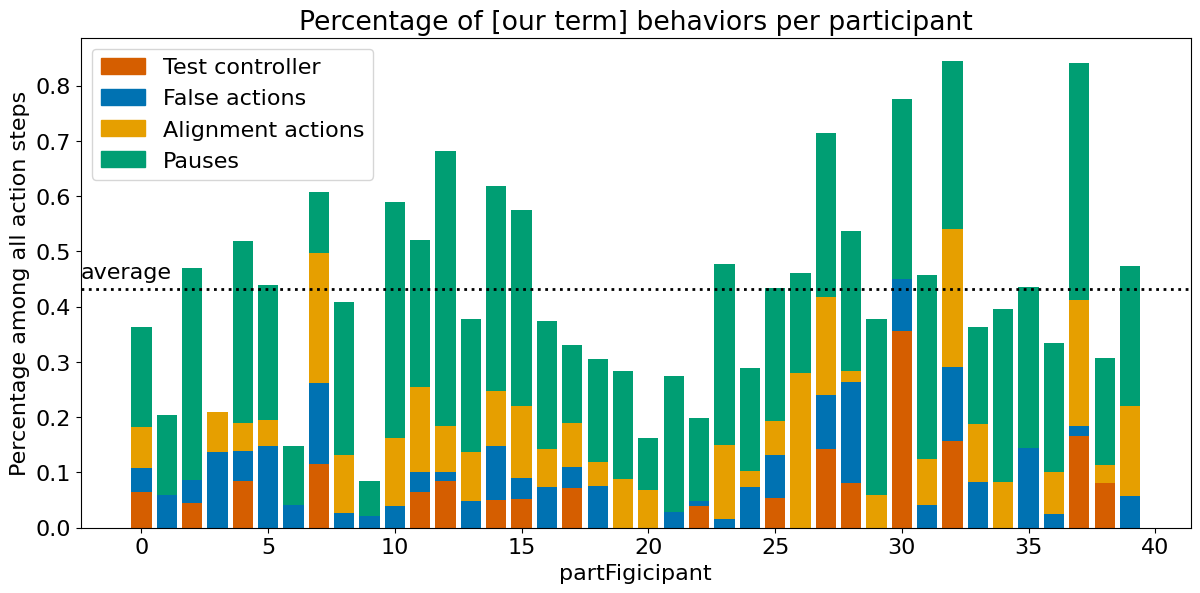

In [15]:
def plot_action_percentage_per_participant_with_type(action_per_participant_with_type:dict, eef_poses_dict):
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16*2   # width in inches
    fig_height = (fig_width / 36) * 8 *2# height in inches to maintain 9:6 ratio for each subplot
    plt.figure(figsize=(fig_width, fig_height))
    # color = ['#377eb8', '#ff7f00', '#4daf4a',
    #               '#f781bf', '#a65628', '#984ea3',
    #               '#999999', '#e41a1c', '#dede00']
            # shuffle
    # random.shuffle(color)

    color = ["#D55E00", "#0072B2", "#E69F00", "#009E73", "#F0E442", "#56B4E9"]

    # loop through all participants
    for i in range(40):
        if f"user_{i}" in action_per_participant_with_type.keys():
            # plot different types of actions on top of each other
            # use the same color for the same type of action
            
            plt.bar(i, action_per_participant_with_type[f"user_{i}"][0]/ len(eef_poses_dict[f"user_{i}"]), label='test controller', color=color[0])
            plt.bar(i, action_per_participant_with_type[f"user_{i}"][1]/ len(eef_poses_dict[f"user_{i}"]), bottom=(action_per_participant_with_type[f"user_{i}"][0])/len(eef_poses_dict[f"user_{i}"]), label='false actions', color=color[1])
            plt.bar(i, action_per_participant_with_type[f"user_{i}"][2]/ len(eef_poses_dict[f"user_{i}"]), bottom=(action_per_participant_with_type[f"user_{i}"][0]+action_per_participant_with_type[f"user_{i}"][1])/len(eef_poses_dict[f"user_{i}"]), label='alignment actions', color=color[2])
            plt.bar(i, action_per_participant_with_type[f"user_{i}"][3]/ len(eef_poses_dict[f"user_{i}"]), bottom=(action_per_participant_with_type[f"user_{i}"][0]+action_per_participant_with_type[f"user_{i}"][1]+action_per_participant_with_type[f"user_{i}"][2])/len(eef_poses_dict[f"user_{i}"]), label='pauses', color=color[3])
    #manual legend since we are plotting multiple times  
    test_controller_patch = mpatches.Patch(color=color[0], label='Test controller')
    false_actions_patch = mpatches.Patch(color=color[1], label='False actions')
    alignment_actions_patch = mpatches.Patch(color=color[2], label='Alignment actions')
    pauses_patch = mpatches.Patch(color=color[3], label='Pauses')


    plt.axhline(y=np.mean([sum(action_per_participant_with_type[f"user_{i}"])/len(eef_poses_dict[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]), color='black', linestyle='dotted', linewidth=2)
    print("average number of actions: ", np.mean([sum(action_per_participant_with_type[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]))
    plt.text(-2.4, 0.02 + np.mean([sum(action_per_participant_with_type[f"user_{i}"])/len(eef_poses_dict[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]), 'average', color='black')


    plt.xlabel('partFigicipant')
    plt.ylabel('Percentage among all action steps')
    plt.title('Percentage of [our term] behaviors per participant')
    plt.legend(handles=[test_controller_patch, false_actions_patch, alignment_actions_patch, pauses_patch])
    plt.show()



action_steps_per_participant_with_type = dict()
for i in range(40):
    if not f"user_{i}" in action_steps_per_participant_with_type.keys():
        action_steps_per_participant_with_type[f"user_{i}"] = [0,0,0,0]


    if f"user_{i}" in action_steps_per_participant_test_controller.keys():
        action_steps_per_participant_with_type[f"user_{i}"][0] += action_steps_per_participant_test_controller[f"user_{i}"]
    if f"user_{i}" in action_steps_per_participant_false_actions.keys():
        action_steps_per_participant_with_type[f"user_{i}"][1] += action_steps_per_participant_false_actions[f"user_{i}"]
    if f"user_{i}" in action_steps_per_participant_alignment_actions.keys():
        action_steps_per_participant_with_type[f"user_{i}"][2] += action_steps_per_participant_alignment_actions[f"user_{i}"]
    if f"user_{i}" in action_steps_per_participant_pauses.keys():
        action_steps_per_participant_with_type[f"user_{i}"][3] += action_steps_per_participant_pauses[f"user_{i}"]

print(action_steps_per_participant_with_type)
plot_action_percentage_per_participant_with_type(action_steps_per_participant_with_type, eef_poses_dict)
    

average number of actions:  14.2
std 10.543244282477762
total_test_controller_actions:  0.05269161823021348
total_false_actions:  0.0540496496278994
total_alignment_actions:  0.09598565918844043
total_pauses:  0.28290510076592973
all actions:  0.48563202781248305


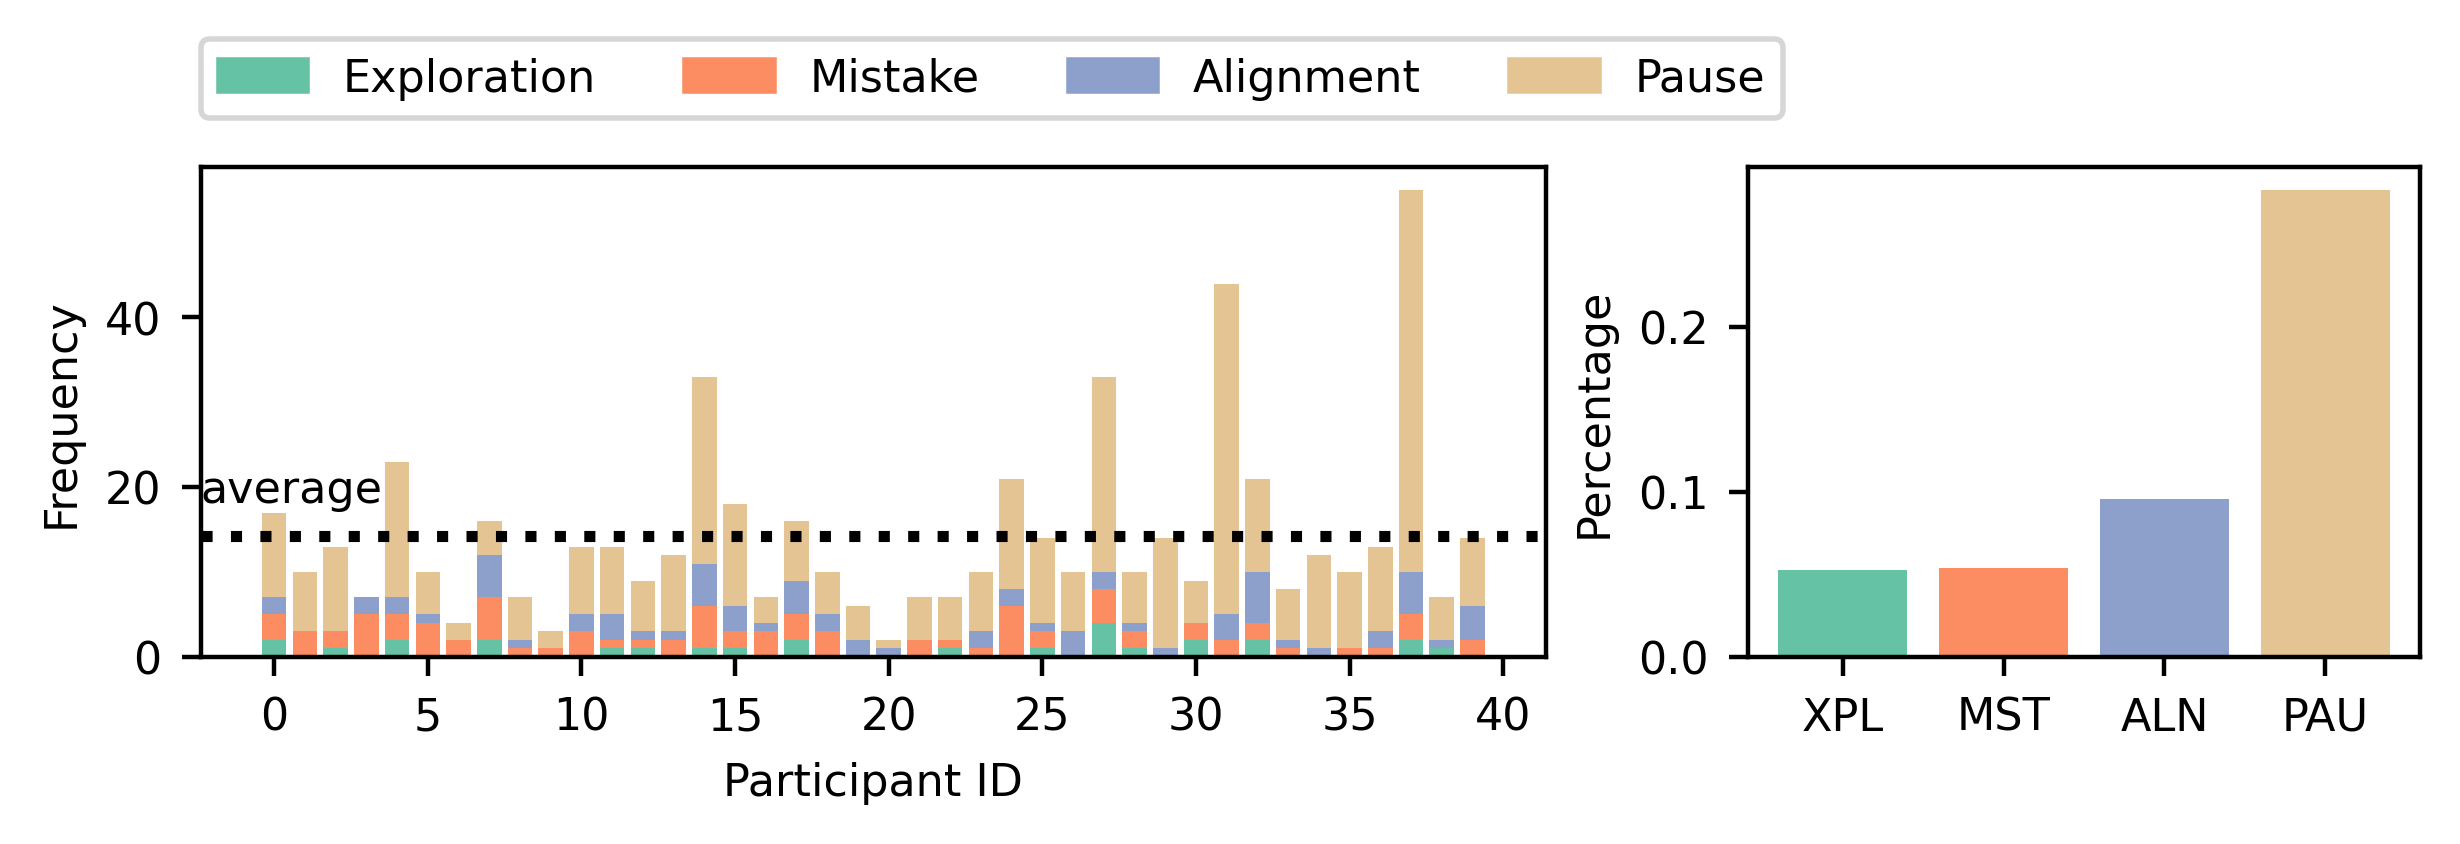

In [16]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

def final_frequency_plot(action_per_participant_with_type, all_test_controller_actions, all_false_actions, all_pauses, all_alignment_actions, eef_poses_dict):
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# Set the font size to match IEEE standard
    plt.rcParams.update({'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 
                         'axes.prop_cycle': plt.cycler(color = CB_color_cycle)})

    # Width and height for a double-column figure in IEEE format
    fig_width = 7.16   # width in inches
    fig_height = (fig_width / 36) * 8 # height in inches to maintain 9:6 ratio for each subplot
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=400)

    gs = GridSpec(1, 2, width_ratios=[2, 1])

    # color = ['#377eb8', '#ff7f00', '#4daf4a',
    #               '#f781bf', '#a65628', '#984ea3',
    #               '#999999', '#e41a1c', '#dede00']
    # color = ["#D55E00", "#0072B2", "#E69F00", "#009E73", "#F0E442", "#56B4E9"]
    color = sns.color_palette("Set2")
    color[3] = color[6]

            # shuffle
    # random.shuffle(color)
    # loop through all participants

    ax1 = fig.add_subplot(gs[0, 0])

    for i in range(40):
        if f"user_{i}" in action_per_participant_with_type.keys():
            # plot different types of actions on top of each other
            # use the same color for the same type of action
            
            ax1.bar(i, action_per_participant_with_type[f"user_{i}"][0], label='test controller', color=color[0])
            ax1.bar(i, action_per_participant_with_type[f"user_{i}"][1], bottom=action_per_participant_with_type[f"user_{i}"][0], label='false actions', color=color[1])
            ax1.bar(i, action_per_participant_with_type[f"user_{i}"][2], bottom=action_per_participant_with_type[f"user_{i}"][0]+action_per_participant_with_type[f"user_{i}"][1], label='alignment actions', color=color[2])
            ax1.bar(i, action_per_participant_with_type[f"user_{i}"][3], bottom=action_per_participant_with_type[f"user_{i}"][0]+action_per_participant_with_type[f"user_{i}"][1]+action_per_participant_with_type[f"user_{i}"][2], label='pauses', color=color[3])
    #manual legend since we are plotting multiple times  
    test_controller_patch = mpatches.Patch(color=color[0], label='Exploration')
    false_actions_patch = mpatches.Patch(color=color[1], label='Mistake')
    alignment_actions_patch = mpatches.Patch(color=color[2], label='Alignment')
    pauses_patch = mpatches.Patch(color=color[3], label='Pause')


    ax1.axhline(y=np.mean([sum(action_per_participant_with_type[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]), color='black', linestyle='dotted', linewidth=2)
    print("average number of actions: ", np.mean([sum(action_per_participant_with_type[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]))
    print("std", np.std([sum(action_per_participant_with_type[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]))
    ax1.text(-2.4, 4 + np.mean([sum(action_per_participant_with_type[f"user_{i}"]) for i in range(40) if f"user_{i}" in action_per_participant_with_type.keys()]), 'average', color='black')
    # add legend for dotted line
    ax1.set_xlabel('Participant ID')
    ax1.set_ylabel('Frequency')


    ax2 = fig.add_subplot(gs[0, 1])


    total_test_controller_actions = 0
    total_false_actions = 0
    total_alignment_actions = 0
    total_pauses = 0
    total_steps = 0

    
    for user_id in eef_poses_dict.keys():
        total_steps += len(eef_poses_dict[user_id])
        if user_id in all_test_controller_actions.keys():
            total_test_controller_actions += np.sum([x[1] - x[0] for x in all_test_controller_actions[user_id]])
        if user_id in all_false_actions.keys():
            total_false_actions += np.sum([x[1] - x[0] for x in all_false_actions[user_id]])
        if user_id in all_alignment_actions.keys():
            total_alignment_actions += np.sum([x[1] - x[0] for x in all_alignment_actions[user_id]])
        if user_id in all_pauses.keys():
            total_pauses += np.sum([x[1] - x[0] for x in all_pauses[user_id]])

    ax2.bar(0, total_test_controller_actions/total_steps, label='test controller', color=color[0])
    ax2.bar(1, total_false_actions/total_steps, label='false actions', color=color[1])
    ax2.bar(2, total_alignment_actions/total_steps, label='alignment actions', color=color[2])
    ax2.bar(3, total_pauses/total_steps, label='pauses', color=color[3])
    print("total_test_controller_actions: ", total_test_controller_actions / total_steps)
    print("total_false_actions: ", total_false_actions / total_steps)
    print("total_alignment_actions: ", total_alignment_actions / total_steps)
    print("total_pauses: ", total_pauses / total_steps)
    print("all actions: ", total_test_controller_actions/total_steps + total_false_actions/total_steps + total_alignment_actions/total_steps + total_pauses/total_steps)

    ax2.set_xticks(range(4),["XPL", "MST", "ALN", "PAU"])
    ax2.set_ylabel('Percentage')

    plt.legend(handles=[test_controller_patch, false_actions_patch, alignment_actions_patch, pauses_patch],loc = [-2.3,1.1], ncol=4)


    



final_frequency_plot(action_per_participant_with_type, all_test_controller_actions, all_false_actions, all_pauses, all_alignment_actions, eef_poses_dict)
    




In [17]:
# try to use GMM to fit the data

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.stats import probplot
from scipy.stats import shapiro
# print(all_test_controller_actions.values())
# print(eef_poses_dict.values())
def analyze_norm(all_actions, eef_poses_dict):
    X = []
    for user_id in all_actions.keys():
        action_list = all_actions[user_id]
        if not len(action_list) == 0:
            for action in action_list:
                # get the eef poses for each action
                
                # we assume clean data is uniform change from start eef pose to end eef pose
                clean_data = eef_poses_dict[user_id][action[0]:action[1]]
                # make a uniform change from start to end
                start = clean_data[0]
                end = clean_data[-1]
                diff = end - start
                # get clean data per step
                clean_data = [start + diff * i/(len(clean_data)-1) for i in range(len(clean_data))]
                # noisy part is actual eef pose - clean data
                noisy_part = eef_poses_dict[user_id][action[0]:action[1]] - clean_data

                actual_action = np.diff(eef_poses_dict[user_id][action[0]:action[1]], axis=0)
                clean_actions = np.diff(clean_data, axis=0)
                # noisy part is actual eef pose - clean data
                noisy_actions = actual_action - clean_actions
                X.append(noisy_actions)
    X = np.concatenate(X)

    for i in range(6):
        plt.figure()
        probplot(X[:,i], plot=plt)
    
    # check if the data is normal
    for i in range(6):
        stat, p = shapiro(X[:,i])
        if p > 0.05:
            print(f"feature {i} is normal")
        else:
            print(f"feature {i} is not normal")

    print("x shape: ", np.array(X).shape)


def fit_gmm(all_actions, eef_poses_dict):
    X = []
    for user_id in all_actions.keys():
        action_list = all_actions[user_id]
        if not len(action_list) == 0:
            for action in action_list:
                # get the eef poses for each action
                
                # we assume clean data is uniform change from start eef pose to end eef pose
                clean_data = eef_poses_dict[user_id][action[0]:action[1]]
                # make a uniform change from start to end
                start = clean_data[0]
                end = clean_data[-1]
                diff = end - start
                # get clean data per step
                clean_data = [start + diff * i/(len(clean_data)-1) for i in range(len(clean_data))]

                actual_action = np.diff(eef_poses_dict[user_id][action[0]:action[1]], axis=0)
                clean_actions = np.diff(clean_data, axis=0)
                # noisy part is actual eef pose - clean data
                noisy_actions = actual_action - clean_actions
                # noisy_part = eef_poses_dict[user_id][action[0]:action[1]] - clean_data
                # print(np.max(noisy_actions, axis=0))
                X.append(noisy_actions)
    X = np.concatenate(X)
    X = X * 1000
    # n_components = [1,2,3, 4, 5, 6, 7, 8, 9, 10]
    n_components = [3]
    for i in range(6):
        bics = []
        aics = []
        log_likelihoods = []
        for n in n_components:
            gmm = GaussianMixture(n_components=n)
            gmm.fit(X[:,i].reshape(-1,1))
            bics.append(gmm.bic(X# functions for procssing annotation data relative to task phase change
def calculate_percentage_to_phase_change(all_task_phase_change, false_actions, eef_poses_dict):
    percentage_to_phase_change = dict()
    closest_phase_change_index = dict()
    steps_to_phase_change = dict()
    for user_id, task_phase_change in all_task_phase_change.items():
        user_eef_poses = eef_poses_dict[user_id]
        task_phase_change = np.array(task_phase_change)
        percentage_to_phase_change[user_id] = []
        closest_phase_change_index[user_id] = []
        steps_to_phase_change[user_id] = []
        for action in false_actions[user_id]:
            # find the closest previous task phase change
            # for act in action:
            act = action[0]
            
            # clear pause steps
            act = clear_pause_steps(user_eef_poses, act, action[1])

            # ignore all actions after task end
            if act > task_phase_change[-1]:
                continue
            closest_phase_change = task_phase_change[task_phase_change <= act]
            if len(closest_phase_change) == 0:
                closest_phase_change = 0
                closest_phase_change_index[user_id].append(0)
            else:
                closest_phase_change = closest_phase_change.max()
                # get the index of the closest phase change
                clo[:,i].reshape(-1,1)))
            aics.append(gmm.aic(X[:,i].reshape(-1,1)))
            log_likelihoods.append(gmm.score(X[:,i].reshape(-1,1)))
            # plot the gmm with the real data

            x = np.linspace(X[:,i].min(), X[:,i].max(), 1000)
            y = np.exp(gmm.score_samples(x.reshape(-1,1)))
            y_real = np.histogram(X[:,i], bins=100, density=True,)
            print("y_real: ", y_real)
            plt.figure()
            plt.plot(x, y)
            plt.plot(y_real[1][:-1], y_real[0])
    plt.figure()
    plt.plot(n_components, bics, label='BIC')
    plt.plot(n_components, aics, label='AIC')
    plt.plot(n_components, log_likelihoods, label='log likelihood')
    plt.xlabel('number of components')  
    plt.ylabel('score')
    plt.title(f'feature {i} score')


analyze_norm(all_test_controller_actions, eef_poses_dict)
fit_gmm(all_alignment_actions, eef_poses_dict)
# fit_gmm(all_test_controller_actions, eef_poses_dict)
# fit_gmm(all_alignment_actions, eef_poses_dict)

SyntaxError: invalid syntax (1039840299.py, line 86)

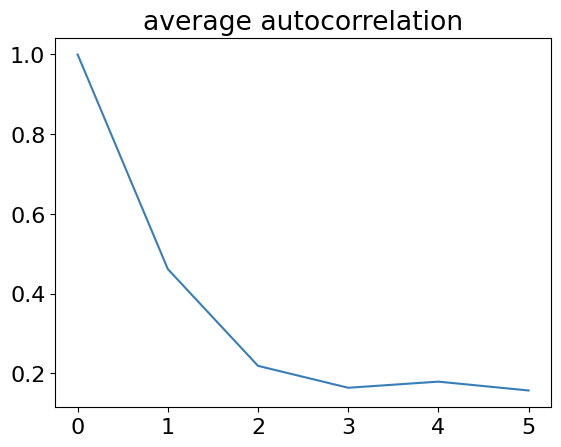

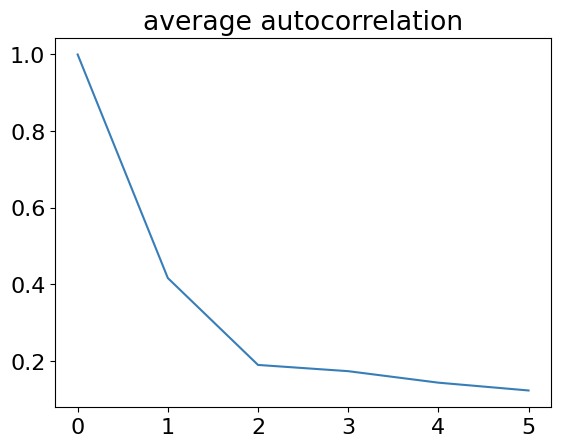

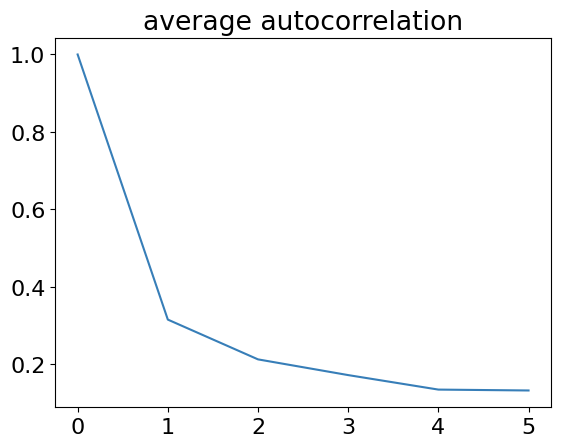

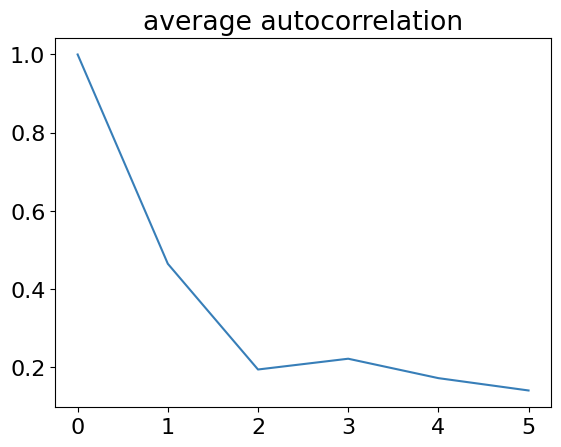

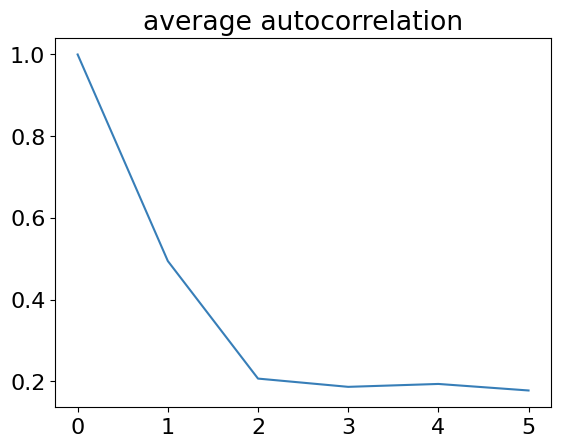

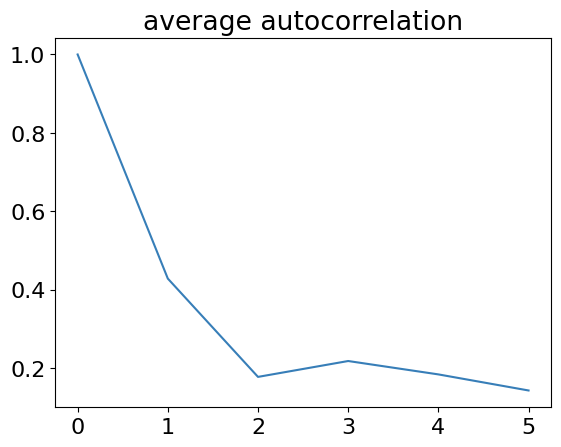

[array([[1.00000000e+00, 5.37308705e-01, 1.01177133e-01, 5.41136307e-02,
         2.42629718e-01, 4.33255030e-01],
        [1.00000000e+00, 6.12531334e-01, 8.92307132e-02, 4.66924128e-01,
         3.68450682e-01, 1.18139521e-01],
        [1.00000000e+00, 7.16400835e-01, 3.57931151e-01, 7.35295273e-02,
         3.61105363e-02, 5.23693700e-02],
        [1.00000000e+00, 6.58116330e-01, 2.02723331e-01, 1.78689143e-02,
         1.01844465e-01, 1.35434318e-01],
        [1.00000000e+00, 7.02190451e-01, 1.42217117e-01, 2.92235938e-01,
         4.13557172e-01, 3.43118555e-01],
        [1.00000000e+00, 3.93027437e-01, 3.94862158e-01, 3.96840391e-01,
         8.97497241e-02, 5.05570176e-04],
        [1.00000000e+00, 8.32462972e-01, 5.31187233e-01, 1.67759879e-01,
         1.61619740e-01, 4.16597701e-01],
        [1.00000000e+00, 2.35350523e-01, 1.35780846e-01, 8.12507370e-03,
         1.92236607e-02, 1.40330028e-01],
        [1.00000000e+00, 7.27022628e-01, 2.75809674e-01, 1.37667075e-01,
       

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_autocorrelation(all_actions, eef_poses_dict):
    X = []
    for user_id in all_actions.keys():
        action_list = all_actions[user_id]
        if not len(action_list) == 0:
            for action in action_list:
                # get the eef poses for each action
                
                # we assume clean data is uniform change from start eef pose to end eef pose
                clean_data = eef_poses_dict[user_id][action[0]:action[1]]
                # make a uniform change from start to end
                start = clean_data[0]
                end = clean_data[-1]
                diff = end - start
                # get clean data per step
                clean_data = [start + diff * i/(len(clean_data)-1) for i in range(len(clean_data))]

                actual_action = np.diff(eef_poses_dict[user_id][action[0]:action[1]], axis=0)
                clean_actions = np.diff(clean_data, axis=0)
                # noisy part is actual eef pose - clean data
                noisy_actions = actual_action - clean_actions
                # noisy_part = eef_poses_dict[user_id][action[0]:action[1]] - clean_data
                print(np.max(noisy_actions, axis=0))
                X.append(noisy_actions)
    X = np.concatenate(X)
    X = X * 1000
    for i in range(6):
        plot_acf(X[:,i])
        plt.title(f'feature {i} autocorrelation')
        plt.show()

from statsmodels.tsa.stattools import acf
def calculate_time_correlation(all_actions, eef_poses_dict):
    X = []
    for user_id in all_actions.keys():
        action_list = all_actions[user_id]
        if not len(action_list) == 0:
            for action in action_list:
                # get the eef poses for each action
                
                # we assume clean data is uniform change from start eef pose to end eef pose
                clean_data = eef_poses_dict[user_id][action[0]:action[1]]
                # make a uniform change from start to end
                start = clean_data[0]
                end = clean_data[-1]
                diff = end - start
                # get clean data per step
                clean_data = [start + diff * i/(len(clean_data)-1) for i in range(len(clean_data))]

                actual_action = np.diff(eef_poses_dict[user_id][action[0]:action[1]], axis=0)
                clean_actions = np.diff(clean_data, axis=0)
                # noisy part is actual eef pose - clean data
                noisy_actions = actual_action - clean_actions
                # noisy_part = eef_poses_dict[user_id][action[0]:action[1]] - clean_data
                # print(np.max(noisy_actions, axis=0))
                X.append(noisy_actions)
    
    # instead of concatenating all actions, we calculate the autocorrelation for each action
    autocorrelations = [[],[],[],[],[],[]]
    for i in range(6):
        for action in X:
            # print(len(action))
            acf_res = acf(action[:,i], nlags=5)
            if len(acf_res) < 6:
                # fill 0 if the length is less than 6
                acf_res = np.concatenate([acf_res, np.zeros(6 - len(acf_res))])
            acf_res = np.abs(acf_res)
            # print(len(action))
            autocorrelations[i].append(acf_res)
    # plot the average autocorrelation
    # print(type(autocorrelations[0]))

    # print(autocorrelations[0].shape)
    autocorrelations = [np.stack(autocorrelations[single_feature]) for single_feature in range(6)]
    for i in range(6):
        plt.plot(np.mean(autocorrelations[i], axis=0))
        plt.title('average autocorrelation')
        plt.show()
    return autocorrelations

# plot_autocorrelation(all_alignment_actions, eef_poses_dict)
# calculate_time_correlation(all_alignment_actions, eef_poses_dict)
calculate_time_correlation(all_test_controller_actions, eef_poses_dict)
    